## Experimentation

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import logging
import torch
import textstat
import nltk

# Importaciones específicas de Code 1 para LLMs y Azure
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from openai import AzureOpenAI
from bert_score import score as bert_score

In [13]:
# --- Configuración inicial ---
nltk.download('punkt', quiet=True)
warnings.filterwarnings("ignore")
# Silenciar warnings de HuggingFace que no son relevantes si BERTScore se usa sin TransformerPipeline
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [33]:
def medir_coherencia(pregunta, respuesta):
    """Mide la coherencia entre una pregunta y su respuesta utilizando BERTScore."""
    P, R, F1 = bert_score([respuesta], [pregunta], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])

def medir_personalizacion(perfil_usuario, respuesta):
    """Mide qué tan personalizada es una respuesta en relación con un perfil de usuario."""
    P, R, F1 = bert_score([respuesta], [perfil_usuario], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])

def medir_fluidez(texto):
    """Mide la fluidez de un texto utilizando el índice de facilidad de lectura de Flesch."""
    return textstat.flesch_reading_ease(texto)

def medir_alucinacion(respuesta, contexto_fuente):
    """Mide la alucinación comparando la respuesta con un contexto fuente (usando BERTScore)."""
    P, R, F1 = bert_score([respuesta], [contexto_fuente], lang="en", model_type="roberta-base", rescale_with_baseline=False)
    return float(F1[0])


In [34]:
# 1. Cargar credenciales desde JSON
def cargar_credenciales(ruta_credenciales):
    with open(ruta_credenciales, "r") as file:
        return json.load(file)

# 2. Crear cliente AzureOpenAI
def crear_cliente_azure(creds):
    client = AzureOpenAI(
        api_key=creds["AZURE_API_KEY"],
        api_version=creds["AZURE_API_VERSION"],
        azure_endpoint=creds["AZURE_ENDPOINT"]
    )
    return client

# 3. Generar embeddings usando cliente (AzureOpenAI)
def text_embedding(text):
    input_text = [text] if isinstance(text, str) else text
    embeddings = client.embeddings.create(model="text-embedding-ada-002",
                                          input=input_text,
                                          encoding_format="float")
    return embeddings.data[0].embedding

# 4. Inicialización Global del Cliente Azure y Credenciales
ruta_credenciales = "credentials.json"
creds = cargar_credenciales(ruta_credenciales)
client = crear_cliente_azure(creds)
modelo_banco = "gpt-35-turbo-16k-PQR"

In [36]:
loader = PyPDFLoader("llm_doc.pdf")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents)


In [37]:
data = [{'Chunks': doc.page_content, 'Metadata': doc.metadata} for doc in doc_splits]
df_vector_store = pd.DataFrame(data)
df_vector_store.head(3)

,Chunks,Metadata
0,Building Pipelines and Environments for \nLar...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'producer': 'Adobe PDF Library 17.0', 'creato..."


In [38]:
df_vector_store["Embedding"] = df_vector_store["Chunks"].apply(lambda x: text_embedding(x))
df_vector_store["Embedding"] = df_vector_store["Embedding"].apply(np.array)
print(f"✅ df_vector_store creado y embeddings aplicados. Filas: {len(df_vector_store)}")


✅ df_vector_store creado y embeddings aplicados. Filas: 46


In [39]:
df_vector_store.head(3)

,Chunks,Metadata,Embedding
0,Building Pipelines and Environments for \nLar...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[-0.001881948, -0.012164683, 0.016830197, -0.0..."
1,Contents\nIntroduction to LLMOps 1\nWhy LLMOps...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[0.0030545578, -0.0043646125, -0.0022074673, -..."
2,1.\nIntroduction to LLMOps\nGenerative AI mode...,"{'producer': 'Adobe PDF Library 17.0', 'creato...","[-0.021225838, -0.008486297, -0.013957637, -0...."


## LLM Evaluation

In [40]:
df_preguntas_respuestas = pd.read_excel("preguntas_BOT.xlsx")
df_preguntas_respuestas.head(10)

,Item,Integrante,Pregunta,Respuesta
0,P1,Katherine,¿Qué son los LLMOps?,Los LLMOps son un marco de herramientas y mejo...
1,P2,Katherine,¿Por qué son importantes los LLMOps?,Los LLMOps son esenciales para superar desafío...
2,P3,Katherine,¿Cuáles son las etapas típicas de un flujo de ...,"Las etapas incluyen: recolección, preparación ..."
3,P4,Katherine,¿Qué implica la etapa de recolección y prepara...,"Consiste en obtener datos, garantizar su calid..."
4,P5,Katherine,¿Cuántos entornos necesita un pipeline típico ...,Un pipeline típico de LLMOps necesita tres ent...
5,P6,Katherine,¿Qué técnica permite a los modelos LLM realiza...,La técnica es el aprendizaje cero (Zero-Shot L...
6,P7,Katherine,¿Qué mide la métrica de LLMs Perplexity?,Mide la sorpresa del modelo ante nuevos datos....
7,P8,Katherine,¿Cómo se evalúan los LLMs y sus prompts?,"Se utilizan métricas como Perplexity, BLEU, RO..."
8,P9,Katherine,¿Cuáles son algunas técnicas de optimización p...,"Algunas técnicas son la destilación, la cuanti..."
9,P10,Katherine,¿Por qué es importante el monitoreo en un ento...,Porque la distribución de datos cambia con el ...


In [41]:
# --- Datos de referencia ---
perfil_usuario = "Usuario colombiano interesado en modelos de lenguaje e IA aplicada"
contexto_generico = "Los LLMOps son un conjunto de prácticas para operar, evaluar y monitorear modelos de lenguaje."


In [22]:
resultados = []
for i, row in df_preguntas_respuestas.head(10).iterrows():
    pregunta = str(row["Pregunta"])
    respuesta_humana = str(row["Respuesta"]) # La respuesta de referencia humana del Excel

    print(f"\nProcesando Pregunta {i+1}/{min(10, len(df_preguntas_respuestas))}: '{pregunta[:70]}...'")

    # --- GENERACIÓN DE RESPUESTA DEL MODELO Y CÁLCULO DE SIMILARIDAD ---
    query_embedding_val = text_embedding(pregunta)
    query_vector = np.array(query_embedding_val)

    def cosine_similarity_for_chunks(row_embedding_chunk):
        denominator1 = np.linalg.norm(row_embedding_chunk)
        denominator2 = np.linalg.norm(query_vector)
        dot_prod = np.dot(row_embedding_chunk, query_vector)
        if denominator1 == 0 or denominator2 == 0:
            return 0.0
        return dot_prod / (denominator1 * denominator2)

    top_matched_indices = (
        df_vector_store["Embedding"]
        .apply(cosine_similarity_for_chunks)
        .sort_values(ascending=False)[:5]
        .index
    )
    context_chunks = list(df_vector_store.loc[top_matched_indices, 'Chunks'])

    custom_prompt = """
    Eres una Inteligencia Artificial super avanzada que trabaja asistente personal.
    Utilice los RESULTADOS DE BÚSQUEDA SEMANTICA para responder las preguntas del usuario.
    Solo debes utilizar la informacion de la BUSQUEDA SEMANTICA si es que hace sentido y tiene relacion con la pregunta del usuario.
    Si la respuesta no se encuentra dentro del contexto de la búsqueda semántica, no inventes una respuesta, y responde amablemente que no tienes información para responder.

    RESULTADOS DE BÚSQUEDA SEMANTICA:
    {source}

    Lee cuidadosamente las instrucciones, respira profundo y escribe una respuesta para el usuario!
    """.format(source = str(context_chunks))

    completion = client.chat.completions.create(
        model=modelo_banco,
        temperature = 0.0,
        messages=[
            {"role": "system", "content": custom_prompt},
            {"role": "user", "content": pregunta}
        ]
    )
    respuesta_modelo = completion.choices[0].message.content

    # Calcular la similaridad entre la respuesta del modelo y la respuesta humana de referencia
    def cosine_final(v1, v2):
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 == 0 or norm_v2 == 0:
            return 0.0
        return np.dot(v1, v2) / (norm_v1 * norm_v2)

    emb_modelo = np.array(text_embedding(respuesta_modelo))
    emb_humana = np.array(text_embedding(respuesta_humana))

    similitud = cosine_final(emb_modelo, emb_humana)

    # --- CÁLCULO DE LAS OTRAS MÉTRICAS (AHORA SOBRE LA RESPUESTA DEL MODELO) ---
    coherencia = medir_coherencia(pregunta, respuesta_modelo) # Coherencia de la respuesta del modelo
    personalizacion = medir_personalizacion(perfil_usuario, respuesta_modelo) # Personalización de la respuesta del modelo
    fluidez = medir_fluidez(respuesta_modelo) # Fluidez de la respuesta del modelo
    alucinacion = medir_alucinacion(respuesta_modelo, contexto_generico) # Alucinación de la respuesta del modelo

    # Agregando resultados al listado final
    resultados.append({
        "Pregunta": pregunta,
        "Respuesta_Humana": respuesta_humana,
        "Respuesta_Modelo_Generada": respuesta_modelo,
        "Coherencia": round(coherencia, 3),
        "Personalización": round(personalizacion, 3),
        "Fluidez": round(fluidez, 2),
        "Alucinación": round(alucinacion, 3),
        "Similaridad_Modelo_Humana": round(similitud, 3)
    })


Procesando Pregunta 1/10: '¿Qué son los LLMOps?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 2/10: '¿Por qué son importantes los LLMOps?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 3/10: '¿Cuáles son las etapas típicas de un flujo de trabajo LLMOps?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 4/10: '¿Qué implica la etapa de recolección y preparación de datos?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 5/10: '¿Cuántos entornos necesita un pipeline típico de LLMOps y cómo se mane...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 6/10: '¿Qué técnica permite a los modelos LLM realizar tareas sin necesidad d...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 7/10: '¿Qué mide la métrica de LLMs Perplexity?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 8/10: '¿Cómo se evalúan los LLMs y sus prompts?...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 9/10: '¿Cuáles son algunas técnicas de optimización postentrenamiento para mo...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio


Procesando Pregunta 10/10: '¿Por qué es importante el monitoreo en un entorno de producción con mo...'


The following layers were not sharded: encoder.layer.*.attention.output.LayerNorm.weight, pooler.dense.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.self.query.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.LayerNorm.bias, embeddings.LayerNorm.weight, encoder.layer.*.output.dense.bias, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.bias, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.intermediate.dense.weight
The following layers were not sharded: encoder.layer.*.attentio

In [23]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Pregunta,Respuesta_Humana,Respuesta_Modelo_Generada,Coherencia,Personalización,Fluidez,Alucinación,Similaridad_Modelo_Humana
0,¿Qué son los LLMOps?,Los LLMOps son un marco de herramientas y mejo...,"Los LLMOps, o Large Language Model Operations,...",0.777,0.817,9.55,0.855,0.913
1,¿Por qué son importantes los LLMOps?,Los LLMOps son esenciales para superar desafío...,Los LLMOps son importantes porque se enfocan e...,0.781,0.801,9.98,0.831,0.946
2,¿Cuáles son las etapas típicas de un flujo de ...,"Las etapas incluyen: recolección, preparación ...",Las etapas típicas de un flujo de trabajo LLMO...,0.842,0.817,46.52,0.847,0.915
3,¿Qué implica la etapa de recolección y prepara...,"Consiste en obtener datos, garantizar su calid...",La etapa de recolección y preparación de datos...,0.855,0.807,16.08,0.832,0.902
4,¿Cuántos entornos necesita un pipeline típico ...,Un pipeline típico de LLMOps necesita tres ent...,Un pipeline típico de LLMOps necesita tres ent...,0.828,0.805,30.42,0.821,0.961
5,¿Qué técnica permite a los modelos LLM realiza...,La técnica es el aprendizaje cero (Zero-Shot L...,La técnica que permite a los modelos LLM reali...,0.874,0.816,27.01,0.834,0.968
6,¿Qué mide la métrica de LLMs Perplexity?,Mide la sorpresa del modelo ante nuevos datos....,La métrica de Perplexity en los Modelos de Len...,0.837,0.836,39.33,0.855,0.908
7,¿Cómo se evalúan los LLMs y sus prompts?,"Se utilizan métricas como Perplexity, BLEU, RO...",La evaluación de los LLMs y sus prompts es un ...,0.772,0.790,17.24,0.811,0.857
8,¿Cuáles son algunas técnicas de optimización p...,"Algunas técnicas son la destilación, la cuanti...",Algunas técnicas de optimización postentrenami...,0.845,0.804,17.84,0.827,0.845
9,¿Por qué es importante el monitoreo en un ento...,Porque la distribución de datos cambia con el ...,El monitoreo en un entorno de producción con m...,0.848,0.806,16.87,0.828,0.921


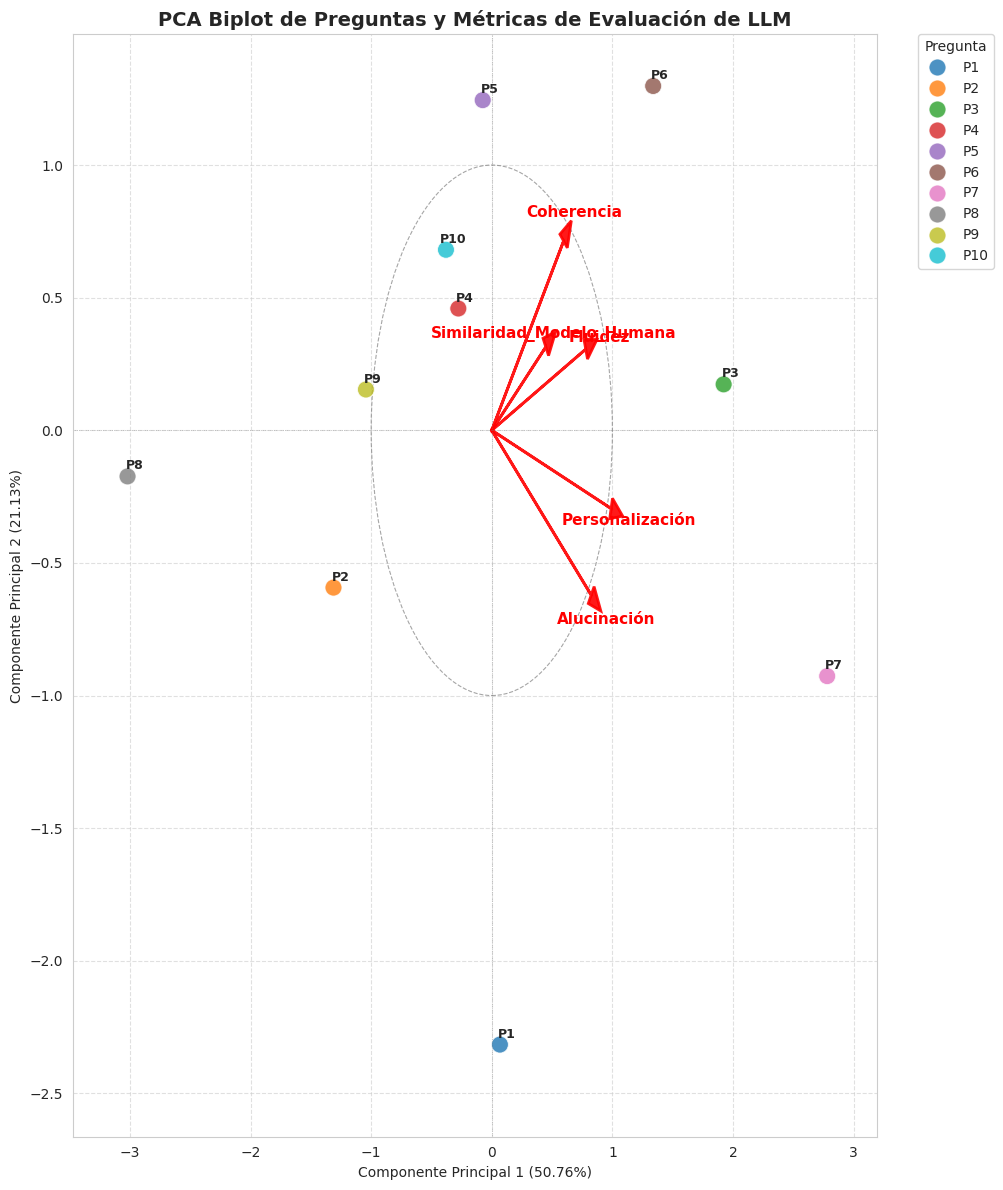

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seleccionar solo las columnas de métricas numéricas para el PCA
metricas_cols = [
    'Coherencia',
    'Personalización',
    'Fluidez',
    'Alucinación',
    'Similaridad_Modelo_Humana'
]

# Crear el DataFrame de solo métricas
X = df_resultados[metricas_cols]

# --- PASO 2: Preparar los datos para PCA (Normalización/Escalado) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PASO 3: Aplicar PCA ---
pca = PCA(n_components=2) # Reducir a 2 componentes principales para la visualización 2D
components = pca.fit_transform(X_scaled)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# --- MODIFICACIÓN CLAVE AQUÍ: USAR LA COLUMNA 'Item' DE df_preguntas_respuestas PARA LAS ETIQUETAS ---
# Necesitamos acceder a df_preguntas_respuestas para obtener los 'Item' (P1, P2, etc.)
# Asumimos que df_preguntas_respuestas también está en memoria, o lo cargamos si no lo está.
# Si ejecutas este script por separado, asegúrate de que df_preguntas_respuestas se carga.
# Por ejemplo: df_preguntas_respuestas = pd.read_excel("preguntas_BOT.xlsx")

# Asegurarse de que tenemos los 'Item' correspondientes a las primeras 10 preguntas evaluadas.
# El df_resultados tiene las 'Pregunta' originales, podemos usar el índice para mapear a 'Item'.
# Asumiendo que df_resultados se construyó en el mismo orden que df_preguntas_respuestas.head(10)
df_pca['Item'] = df_preguntas_respuestas['Item'].head(len(df_pca)).tolist()


# --- PASO 4: Calcular las correlaciones para las direcciones de las variables ---
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear un DataFrame para los loadings
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=metricas_cols)

# --- PASO 5: Visualizar el biplot ---
plt.figure(figsize=(12, 12)) # Aumentar ligeramente el tamaño para mejor visualización
sns.set_style("whitegrid")

# Dibujar las preguntas (observaciones) como puntos
# Usamos 'Item' para el hue y las etiquetas
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='Item', s=150, alpha=0.8, edgecolor='w', linewidth=0.7, zorder=2) # Aumentar tamaño y zorder

# Añadir etiquetas a cada punto (Pregunta) usando la columna 'Item' (P1, P2, etc.)
for i, txt in enumerate(df_pca['Item']):
    plt.annotate(txt, (df_pca['PC1'][i], df_pca['PC2'][i]),
                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, fontweight='bold', zorder=3)


# Dibujar el círculo unitario para interpretar las correlaciones
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
plt.gca().add_patch(circle)

# Ajustar los límites del plot para que todo quepa bien
x_min, x_max = df_pca['PC1'].min(), df_pca['PC1'].max()
y_min, y_max = df_pca['PC2'].min(), df_pca['PC2'].max()

x_min_load, x_max_load = df_loadings['PC1'].min(), df_loadings['PC1'].max()
y_min_load, y_max_load = df_loadings['PC2'].min(), df_loadings['PC2'].max()

overall_min_x = min(x_min, x_min_load, -1.1) # Incluye el límite del círculo
overall_max_x = max(x_max, x_max_load, 1.1)
overall_min_y = min(y_min, y_min_load, -1.1)
overall_max_y = max(y_max, y_max_load, 1.1)

margin = 0.15 # 15% de margen
plt.xlim(overall_min_x - abs(overall_min_x * margin), overall_max_x + abs(overall_max_x * margin))
plt.ylim(overall_min_y - abs(overall_min_y * margin), overall_max_y + abs(overall_max_y * margin))


# Dibujar las flechas para las variables (métricas)
for i, var in enumerate(metricas_cols):
    plt.arrow(0, 0, df_loadings['PC1'][i], df_loadings['PC2'][i],
              color='red', alpha=0.9, lw=2, head_width=0.08, head_length=0.1, zorder=2)
    plt.text(df_loadings['PC1'][i] * 1.15, df_loadings['PC2'][i] * 1.15, # Posición del texto ligeramente fuera
             var, color='red', ha='center', va='center', fontsize=11, fontweight='bold', zorder=3)

plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA Biplot de Preguntas y Métricas de Evaluación de LLM', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', lw=0.5, linestyle=':', alpha=0.7)
plt.axvline(0, color='gray', lw=0.5, linestyle=':', alpha=0.7)
plt.legend(title='Pregunta', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar layout para hacer espacio para la leyenda
plt.show()
